# Tutorial for solving the Schrödinger equation in 1D using Classical Splittings (`expsolve.splittings`)

This notebook introduces you to the basic functionalities of `expsolve.splittings` with the example of the Schrödinger equation in 1D. We will use `expsolve.fourier` as our spatial discretiser, and import it as `ex`. Specifically, we will consider classical splittings, available in `expsolve.splittings.classical`, which we import as `split`.

*&#169; Copyright 2019-2022 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag
from torch.linalg import matrix_exp

# Time-dependent potential 

The linear time-dependent Schrödinger equation in 1D with with time-dependent Hamiltonian can be written in the following form

$$ i \partial_t \psi(x,t) = \mathrm{H}(t) \psi(x,t), \qquad x \in [-L,L] $$

We consider explicitly time-dependent Hamiltonian operators $\mathrm{H}(t)$ of the form

$$ \mathrm{H} = -\partial_x^2 + V(x,t) $$

e.g. 

$$ V(x,t) = V_0(x) + c_1 e^{-\frac{(x-(x_0+t)).^2}{2\sigma^2}}\sin(8 \pi (x-t)) - c_2 \sin(5 \pi t)x $$

for $x_0 = -2$, $c_1 = c_2 = 10^2$, $\sigma = 0.5$.

We can implement this using a classical splitting by introducing an internal time that advances with each action of $-\partial_x^2$. 

Specifically, we compute

$$u_{n+1} = \exp\left(- i h \beta_K V(\tau_K) \right) \exp\left(i h \alpha_K\, \mathbf{D}_2\right) \ldots \exp\left(- i h \beta_2 V(\tau_2) \right) \exp\left(i h \alpha_2\, \mathbf{D}_2\right) \exp\left(- i h \beta_1 V(\tau_1) \right) \exp\left(i h \alpha_1\, \mathbf{D}_2\right)u_n $$

where 

$$ \tau_k = \tau_{k-1} + \alpha_k, \qquad \tau_0 = t_n $$

In [20]:
sigma = 0.5
c1 = 1e2
c2 = 1e2
x0 = -2

In [21]:
Vt = lambda t : V + c1 * exp(-(x-(x0+t))**2/(2*sigma)) * sin(8*pi*(x-t)) - c2 * sin(5*pi*t) * x

In [1]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVtu = lambda t, tauL, h, c, u: exp(-1j*c*h*Vt(tauL))*u     # is this OK??? Shouldn't it be V(t+tauL)?

In [23]:
trotterstep_Vt = lambda t, h, u0: split.stepper(t, h, u0, eVtu, eLu, trotteralpha, trotterbeta)
strangstep_Vt = lambda t, h, u0: split.stepper(t, h, u0, eVtu, eLu, strangalpha, strangbeta)
blanesmoanstep_Vt = lambda t, h, u0: split.stepper(t, h, u0, eVtu, eLu, blanesmoanalpha, blanesmoanbeta)

In [24]:
trotterevolve_Vt = es.solvediffeq(u, timegrid, trotterstep_Vt, observables)
strangevolve_Vt = es.solvediffeq(u, timegrid, strangstep_Vt, observables)
blanesmoanevolve_Vt = es.solvediffeq(u, timegrid, blanesmoanstep_Vt, observables)

obsvalues_trotter_Vt = trotterevolve_Vt[1]
obsvalues_strang_Vt = strangevolve_Vt[1]
obsvalues_blanesmoan_Vt = blanesmoanevolve_Vt[1]

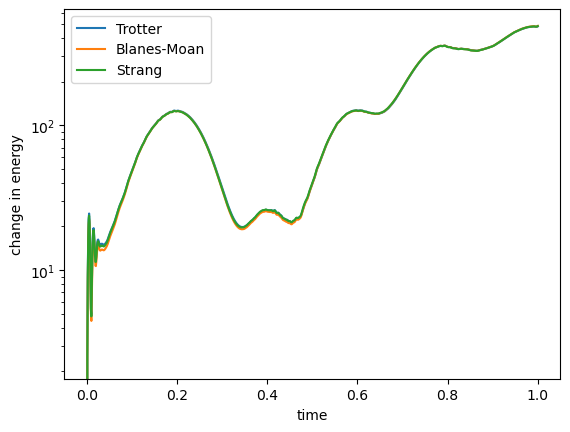

In [25]:
plt.figure()

E0 = obsvalues_trotter['energy'][0][0]

plt.semilogy(timegrid, np.abs(obsvalues_trotter_Vt['energy'][0]-E0))
plt.semilogy(timegrid, np.abs(obsvalues_strang_Vt['energy'][0]-E0))
plt.semilogy(timegrid, np.abs(obsvalues_blanesmoan_Vt['energy'][0]-E0))
plt.legend({'Trotter','Strang','Blanes-Moan'})
plt.ylabel('change in energy')
plt.xlabel('time')
plt.show()

The energy is no longer conserved! That's because we have a time-dependent Hamiltonian now.

## Reference solution

This time around, the brute force solution is very expensive. We compute by sampling $H(t)$ at midpoint $t+\frac{h}{2}$ and exponentiating via `matrix_exp`.

### Warning: will take 5-10 minutes

In [27]:
Ht = lambda t, h: -D2 + es.linalg.diag(Vt(t+h/2))

T = 0.1         # reference too expensive and inaccurate for large T
Nref = 10000

ureft = u
#h = torch.tensor(T/Nref, dtype=torch.float64)
#t = torch.tensor(0., dtype=torch.float64)
tref = es.timegrid(T,Nref)
h = tref[1]-tref[0]

for t in tref:
    ureft = es.linalg.matmul(matrix_exp(-1j*h*Ht(t,h)) , ureft)

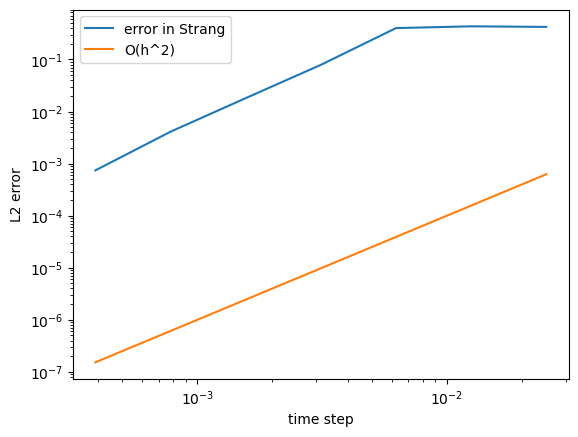

In [28]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [ex.l2norm(ureft-es.solvediffeq(u, es.timegrid(T, N), strangstep_Vt)[0])[0] for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Strang', 'O(h^2)'])
plt.show()

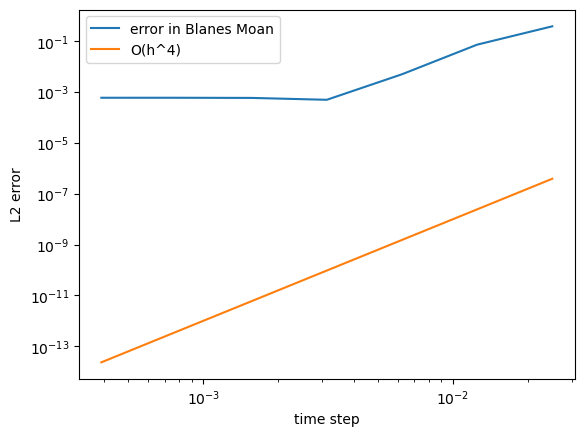

In [30]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [ex.l2norm(ureft-es.solvediffeq(u, es.timegrid(T, N), blanesmoanstep_Vt)[0])[0] for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**4)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Blanes Moan', 'O(h^4)'])
plt.show()

The problem with Blanes-Moan is that the reference is not accurate enough. To check rate of convergence, we can do self referencing instead :

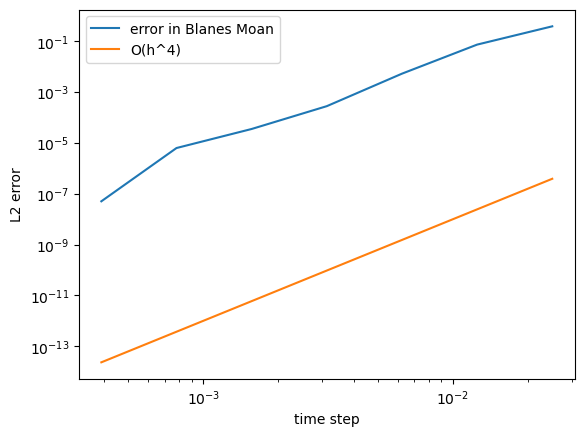

In [29]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

uref_blanesmoan = es.solvediffeq(u, es.timegrid(T, 10000), blanesmoanstep_Vt)[0]

err = [ex.l2norm(uref_blanesmoan-es.solvediffeq(u, es.timegrid(T, N), blanesmoanstep_Vt)[0])[0] for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**4)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Blanes Moan', 'O(h^4)'])
plt.show()